In this notebook we examine whether the G3 compartment represents only the walking/paused state of the fly, or whether it contains information about the fine-scale walking speed of the fly as well.

# Classify walking/paused states using G3

Here we fit a logistic regression classifier to predict the walking ('W') or paused ('P') states for each trial with labeled states.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from aux import make_extended_predictor_matrix
from data import DataLoader
from plot import set_font_size


class ClassifierResult(object):
    
    def __init__(self, trial_id, dans, windows, valid, states, states_pred, coefs, clf):
        self.trial_id = trial_id,
        self.dans = dans
        self.windows = windows
        self.valid = valid
        self.states = states
        self.states_pred = states_pred
        self.coefs = coefs
        self.clf = clf
        
        # get number of valid time points
        self.n_valid = valid.sum()
        
        # get fraction of valid time points in walking state
        self.walk_frac = np.sum(states[valid] == 'W') / self.n_valid
        
        # get accuracy (fraction of correctly labeled valid states)
        if states_pred is not None:
            self.acc = np.sum(states_pred[valid] == states[valid]) / self.n_valid
        else:
            self.acc = np.nan
            
            
def classify_states(trial, windows):
    """
    Fit a classifier predicting a trial's paused vs. walking states
    using activity from a set of neural compartments.
    
    :param trial: trial object
    :param windows: dict of windows to use for each predictive dan
        (keys are DAN names, vals are tuples of (start, end) time
            points relative to time point of prediction)
            
    :return: ClassifierResult
    """
    
    try:
        trial.dl
    except:
        trial.dl = DataLoader(trial, vel_filt=None)
    
    dans = list(windows.keys())
    states = trial.dl.states
    vs = {dan: getattr(trial.dl, dan) for dan in dans}
    
    # make extended dan predictor matrix
    vs_extd = make_extended_predictor_matrix(vs, windows, order=dans)
    
    # make valid mask (not nan predictors and not ambiguous state)
    valid = np.all(~np.isnan(vs_extd), axis=1) & (states != 'A')
    
    if len(set(states[valid])) == 2:
        # at least two states
        
        # fit classifier
        clf = LogisticRegression(n_jobs=-1)
        clf.fit(vs_extd[valid], states[valid])
        
        # make state predictions
        states_pred = np.repeat('', len(states))
        states_pred[valid] = clf.predict(vs_extd[valid])
        
        # get coefficients
        window_lens = [windows[d][1] - windows[d][0] for d in dans]
        splits = np.split(clf.coef_[0], np.cumsum(window_lens)[:-1])
        
        coefs = {d: s for d, s in zip(dans, splits)}
        
    else:
        # fewer than two states
        clf = None
        states_pred = None
        coefs = None
        
    result = ClassifierResult(
        trial_id=trial.id, dans=dans, windows=windows, valid=valid,
        states_pred=states_pred, states=states, coefs=coefs, clf=clf)
    
    return result

In [2]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [24]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
mtnless_mask = [trial.expt == 'motionless' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'motionless': 'r'}

In [4]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, vel_filt=None)

Loading data for trial 1/52 (20170310.Fly2.2)
Loading data for trial 2/52 (20170310.Fly2.6)
Loading data for trial 3/52 (20170310.Fly3.1)
Loading data for trial 4/52 (20170313.Fly1.1)
Loading data for trial 5/52 (20170313.Fly1.2)
Loading data for trial 6/52 (20170313.Fly1.3)
Loading data for trial 7/52 (20170313.Fly1.4)
Loading data for trial 8/52 (20170313.Fly1.8)
Loading data for trial 9/52 (20170313.Fly3.1)
Loading data for trial 10/52 (20170313.Fly3.2)
Loading data for trial 11/52 (20170313.Fly3.3)
Loading data for trial 12/52 (20170330.Fly1.1)
Loading data for trial 13/52 (20170330.Fly1.2)
Loading data for trial 14/52 (20170330.Fly1.4)
Loading data for trial 15/52 (20170330.Fly1.5)
Loading data for trial 16/52 (20170331.Fly1.1)
Loading data for trial 17/52 (20170331.Fly1.2)
Loading data for trial 18/52 (20170331.Fly1.5)
Loading data for trial 19/52 (20170331.Fly1.6)
Loading data for trial 20/52 (20170331.Fly2.4)
Loading data for trial 21/52 (20170331.Fly2.6)
Loading data for trial

# Predict walking speed during walking states using G3

In [5]:
WINDOWS = {
    'G2': {'G2S': (-1, 2)},
    'G3': {'G3S': (-1, 2)},
    'G4': {'G4S': (-1, 2)},
    'G5': {'G5S': (-1, 2)},
}

results_clf = {'G3': [classify_states(trial, WINDOWS['G3']) for trial in trials]}

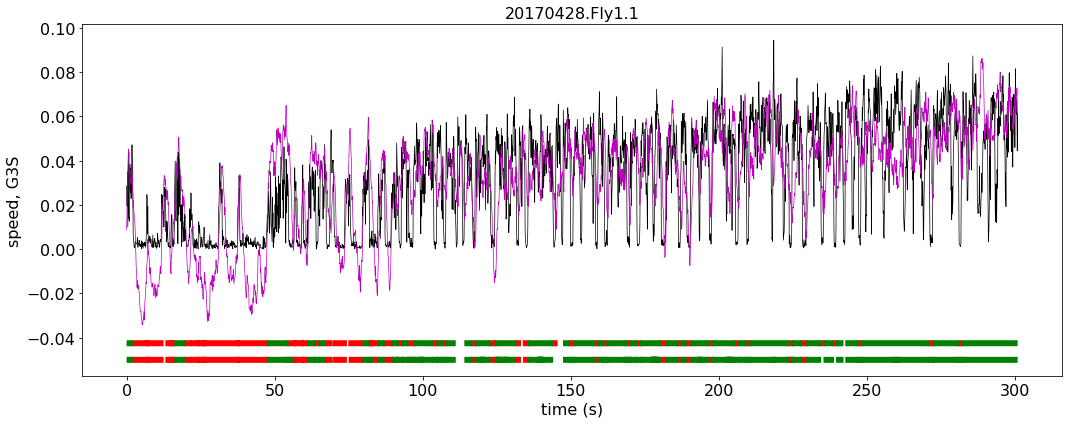

In [6]:
from plot import set_font_size

EXAMPLE = '20170428.Fly1.1'
LINE_YS = [-0.0425, -0.05]
LW = 6

# plot example trial's walking speed, G3S, true state labels, and predicted state labels
trial_idx = [trial.name for trial in trials].index(EXAMPLE)
trial_ex = trials[trial_idx]
res_ex = results_clf['G3'][trial_idx]

fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

ts = trial_ex.dl.timestamp_gcamp
speed = trial_ex.dl.speed
G3S = trial_ex.dl.G3S

# normalize G3S to be plottable atop speed
G3S -= G3S.mean()
G3S /= G3S.std()
G3S *= speed.std()
G3S += speed.mean()

ax.plot(ts, speed, color='k', lw=0.7)
ax.plot(ts, G3S, color='m', lw=0.7)

# plot true state labels, predicted state labels, and 
states_p = np.repeat(np.nan, len(ts))
states_p[res_ex.states == 'P'] = LINE_YS[0]
states_w = np.repeat(np.nan, len(ts))
states_w[res_ex.states == 'W'] = LINE_YS[0]

states_p_pred = np.repeat(np.nan, len(ts))
states_p_pred[res_ex.states_pred == 'P'] = LINE_YS[1]
states_w_pred = np.repeat(np.nan, len(ts))
states_w_pred[res_ex.states_pred == 'W'] = LINE_YS[1]

ax.plot(ts, states_p, lw=LW, color='r')
ax.plot(ts, states_w, lw=LW, color='g')

ax.plot(ts, states_p_pred, lw=LW, color='r')
ax.plot(ts, states_w_pred, lw=LW, color='g')

ax.set_xlabel('time (s)')
ax.set_ylabel('speed, G3S')
ax.set_title(EXAMPLE)

set_font_size(ax, 16)

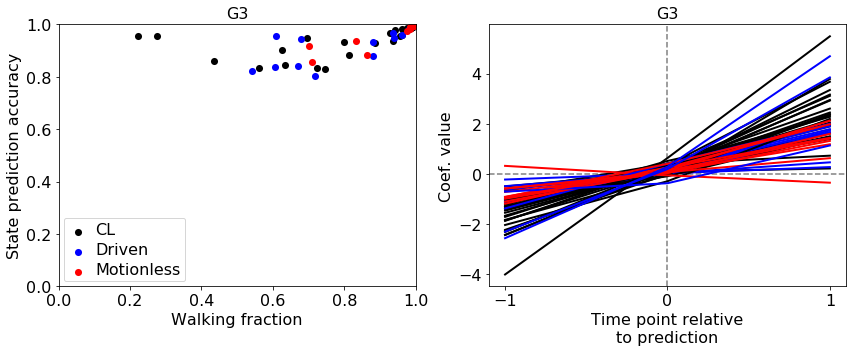

In [7]:
def plot_state_classifications(key, coef, axs):

    walk_fracs = np.array([r.walk_frac for r in results_clf[key]])
    accs = np.array([r.acc for r in results_clf[key]])

    c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'motionless': 'r'}

    axs[0].scatter(walk_fracs[closed_mask], accs[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    axs[0].scatter(walk_fracs[driven_mask], accs[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    axs[0].scatter(walk_fracs[mtnless_mask], accs[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)

    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)

    axs[0].set_xlabel('Walking fraction')
    axs[0].set_ylabel('State prediction accuracy')
    axs[0].set_title(key)
    axs[0].legend(['CL', 'Driven', 'Motionless'], loc='best')

    for r, trial in zip(results_clf[key], trials):
        c = c_dict[trial.expt]

        if r.coefs is not None:
            axs[1].plot(np.arange(*WINDOWS[key][coef]), r.coefs[coef], color=c, lw=2)

    axs[1].axhline(0, color='gray', ls='--', zorder=-1)
    axs[1].axvline(0, color='gray', ls='--', zorder=-1)

    axs[1].set_xlabel('Time point relative\nto prediction')
    axs[1].set_ylabel('Coef. value')

    axs[1].set_xticks(range(*WINDOWS[key][coef]))
    axs[1].set_title(key)

    for ax in axs.flatten():
        set_font_size(ax, 16)
        
# plot accuracy vs. fraction of time spent walking, and G3S coefs
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
plot_state_classifications('G3', 'G3S', axs)

# Predict walking speed during walking epochs using G3S

In [8]:
from sklearn.linear_model import LinearRegression


class RegressionResult(object):
    
    def __init__(self, trial_id, dans, windows, valid, speed, speed_pred, coefs, rgr):
        self.trial_id = trial_id
        self.dans = dans
        self.windows = windows
        self.valid = valid
        self.speed = speed
        self.speed_pred = speed_pred
        self.coefs = coefs
        self.rgr = rgr

        self.n_valid = valid.sum()

        if valid.sum() > 0:
            # calc R^2 val from truth and prediction
            self.err = speed_pred - speed
            self.r2 = (np.nanvar(speed) - np.nanvar(self.err)) / np.nanvar(speed)
        else:
            self.err = np.repeat(np.nan, len(speed))
            self.r2 = np.nan

    
def predict_speeds(trial, windows):
    """
    Predict the walking speeds for each trial during the epochs labeled as walking.
    
    :param trial: trial object
    :param windows: dict of windows to use for each predictive dan
        (keys are DAN names, vals are tuples of (start, end) time
            points relative to time point of prediction)
            
    :return: RegressionResult
    """
    
    try:
        trial.dl
    except:
        trial.dl = DataLoader(trial, vel_filt=None)
    
    dans = list(windows.keys())
    states = trial.dl.states
    speed = trial.dl.speed
    vs = {dan: getattr(trial.dl, dan) for dan in dans}
    
    # make extended dan predictor matrix
    vs_extd = make_extended_predictor_matrix(vs, windows, order=dans)
    
    # mark all non-walking speeds with nan
    speed[states != 'W'] = np.nan
    
    # make valid mask (not nan predictors and not nan speed)
    valid = np.all(~np.isnan(vs_extd), axis=1) & (~np.isnan(speed))
    
    if valid.sum() > 0:
        # at least one valid time point
        
        # fit regression
        rgr = LinearRegression(n_jobs=-1)
        rgr.fit(vs_extd[valid], speed[valid])
        
        # make speed predictions
        speed_pred = np.repeat(np.nan, len(speed))
        speed_pred[valid] = rgr.predict(vs_extd[valid])
        
        # get coefficients
        window_lens = [windows[d][1] - windows[d][0] for d in dans]
        splits = np.split(rgr.coef_, np.cumsum(window_lens)[:-1])
        
        coefs = {d: s for d, s in zip(dans, splits)}
        
    else:
        # fewer than two states
        rgr = None
        speeds_pred = None
        coefs = None
        
    result = RegressionResult(
        trial_id=trial.id, dans=dans, windows=windows, valid=valid,
        speed=speed, speed_pred=speed_pred, coefs=coefs, rgr=rgr)
    
    return result

In [9]:
WINDOWS = {
    'G2': {'G2S': (-1, 2)},
    'G3': {'G3S': (-1, 2)},
    'G4': {'G4S': (-1, 2)},
    'G5': {'G5S': (-1, 2)},
}

In [10]:
results_rgr = {'G3': [predict_speeds(trial, WINDOWS['G3']) for trial in trials]}

### Plot example trial

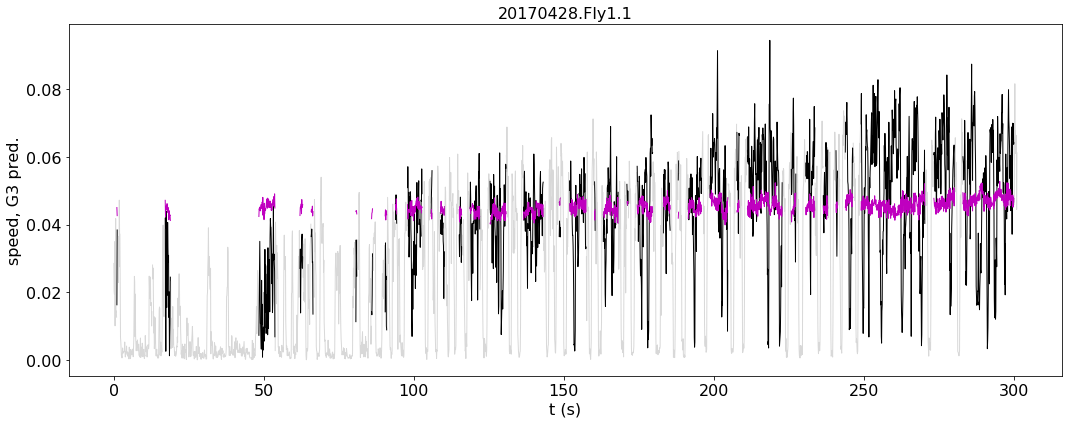

In [11]:
EXAMPLE = '20170428.Fly1.1'

def plot_example_speed_prediction(trial_name, key, fig_size=(15, 6)):

    trial_idx = [trial.name for trial in trials].index(trial_name)
    trial_ex = list(trials)[trial_idx]
    res_ex = results_rgr[key][trial_idx]

    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

    ts = trial_ex.dl.timestamp_gcamp
    speed = trial_ex.dl.speed
    states = trial_ex.dl.states

    # plot speed and prediction during walking bouts
    ax.plot(ts, res_ex.speed, lw=1, color='k')
    ax.plot(ts, res_ex.speed_pred, lw=1, color='m')

    # plot non-walking bout speeds as faint gray lines
    speed_not_walk = speed.copy()
    speed_not_walk[states == 'W'] = np.nan
    ax.plot(ts, speed_not_walk, lw=1, alpha=0.3, color='gray')

    ax.set_xlabel('t (s)')
    ax.set_ylabel('speed, {} pred.'.format(key))
    ax.set_title(trial_name)

    set_font_size(ax, 16)
    
    return ax
    
plot_example_speed_prediction(EXAMPLE, 'G3');

(200, 300)

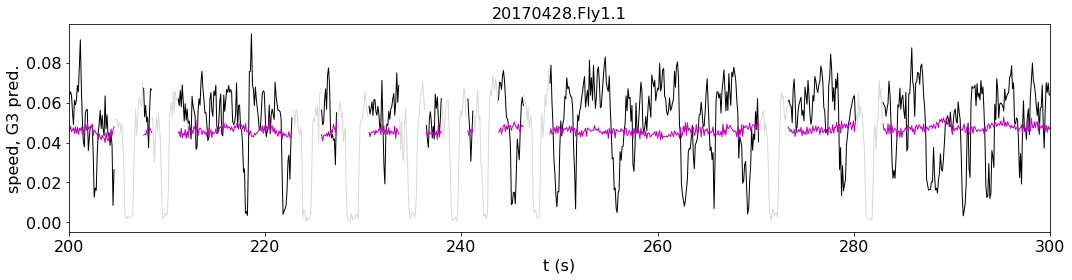

In [12]:
ax = plot_example_speed_prediction(EXAMPLE, 'G3', fig_size=(15, 4))
ax.set_xlim(200, 300)

### Plot R^2 vs. n_valid for all trials

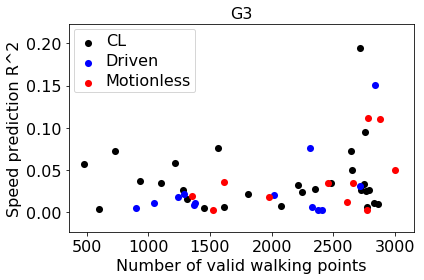

In [13]:
def plot_speed_prediction(key, ax):

    n_valids = np.array([r.n_valid for r in results_rgr[key]])
    r2s = np.array([r.r2 for r in results_rgr[key]])

    ax.scatter(n_valids[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(n_valids[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(n_valids[mtnless_mask], r2s[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)

    ax.set_xlabel('Number of valid walking points')
    ax.set_ylabel('Speed prediction R^2')
    ax.set_title(key)
    ax.legend(['CL', 'Driven', 'Motionless'], loc='best')

    set_font_size(ax, 16)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
plot_speed_prediction('G3', ax)

In [14]:
# make dataframe
df_data = []
for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'Walking Fraction': results_clf['G3'][tr_ctr].walk_frac,
        'State Prediction': results_clf['G3'][tr_ctr].acc,
        'Speed Prediction': results_rgr['G3'][tr_ctr].r2,
    })
    
df = pd.DataFrame(df_data, columns=['Trial', 'Expt', 'Walking Fraction', 'State Prediction', 'Speed Prediction'])
        
df.round(3)

,Trial,Expt,Walking Fraction,State Prediction,Speed Prediction
0,20170310.Fly2.2,closed_loop,0.995,0.995,0.009
1,20170310.Fly2.6,closed_loop,0.996,0.996,0.011
2,20170310.Fly3.1,closed_loop,0.990,0.990,0.025
3,20170313.Fly1.1,closed_loop,0.434,0.860,0.073
4,20170313.Fly1.2,closed_loop,0.813,0.883,0.006
5,20170313.Fly1.3,closed_loop,0.885,0.929,0.021
6,20170313.Fly1.4,closed_loop,0.957,0.957,0.007
7,20170313.Fly1.8,closed_loop,0.937,0.937,0.032
8,20170313.Fly3.1,closed_loop,0.746,0.829,0.004
9,20170313.Fly3.2,closed_loop,0.928,0.967,0.024


### Example trial with relatively high G3-walking speed prediction (20170330.Fly1.1)

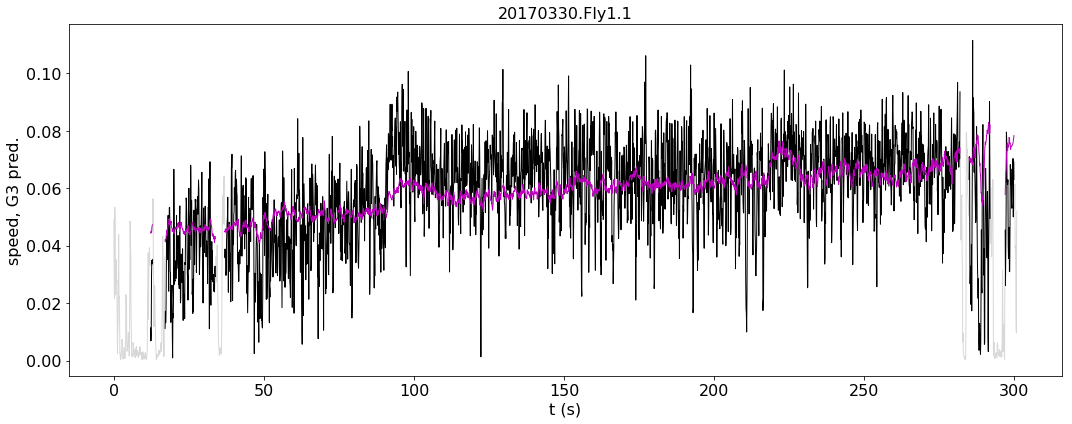

In [15]:
ax = plot_example_speed_prediction('20170330.Fly1.1', 'G3')

### Another example trial with relatively high G3-walking speed prediction (20170428.Fly2.4)

(160, 200)

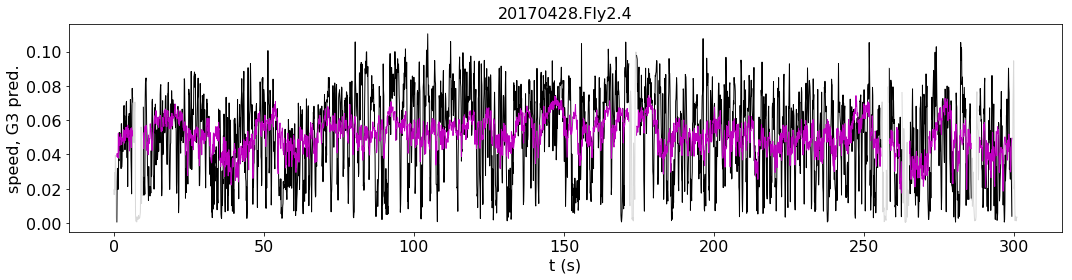

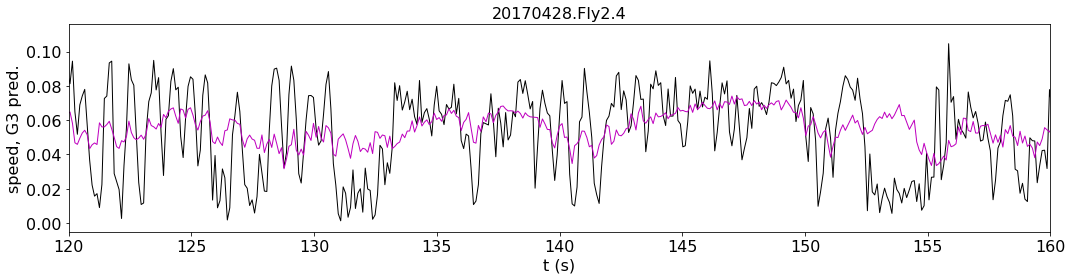

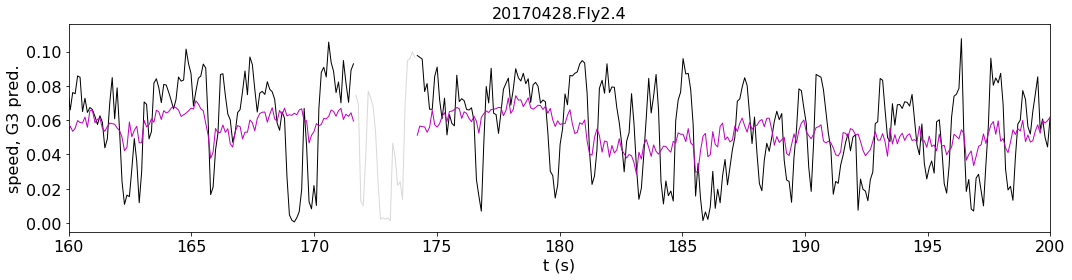

In [16]:
plot_example_speed_prediction('20170428.Fly2.4', 'G3', fig_size=(15, 4))
ax = plot_example_speed_prediction('20170428.Fly2.4', 'G3', fig_size=(15, 4))
ax.set_xlim(120, 160)
ax = plot_example_speed_prediction('20170428.Fly2.4', 'G3', fig_size=(15, 4))
ax.set_xlim(160, 200)

For this trial it seems like the G3 speed prediction may slightly follow some of the large-scale speed fluctuations. Note, however, that this does not appear to be the case for trial "20170428.Fly1.1", which also has many large-scale speed fluctuations during its walking state. If anything, however, it appears to be a very slight effect...

# Compare G3 state classification and speed prediction to that using other compartments

In [17]:
for key in ['G2', 'G4', 'G5']:
    results_clf[key] = [classify_states(trial, WINDOWS[key]) for trial in trials]
    results_rgr[key] = [predict_speeds(trial, WINDOWS[key]) for trial in trials]

### State classification accuracy

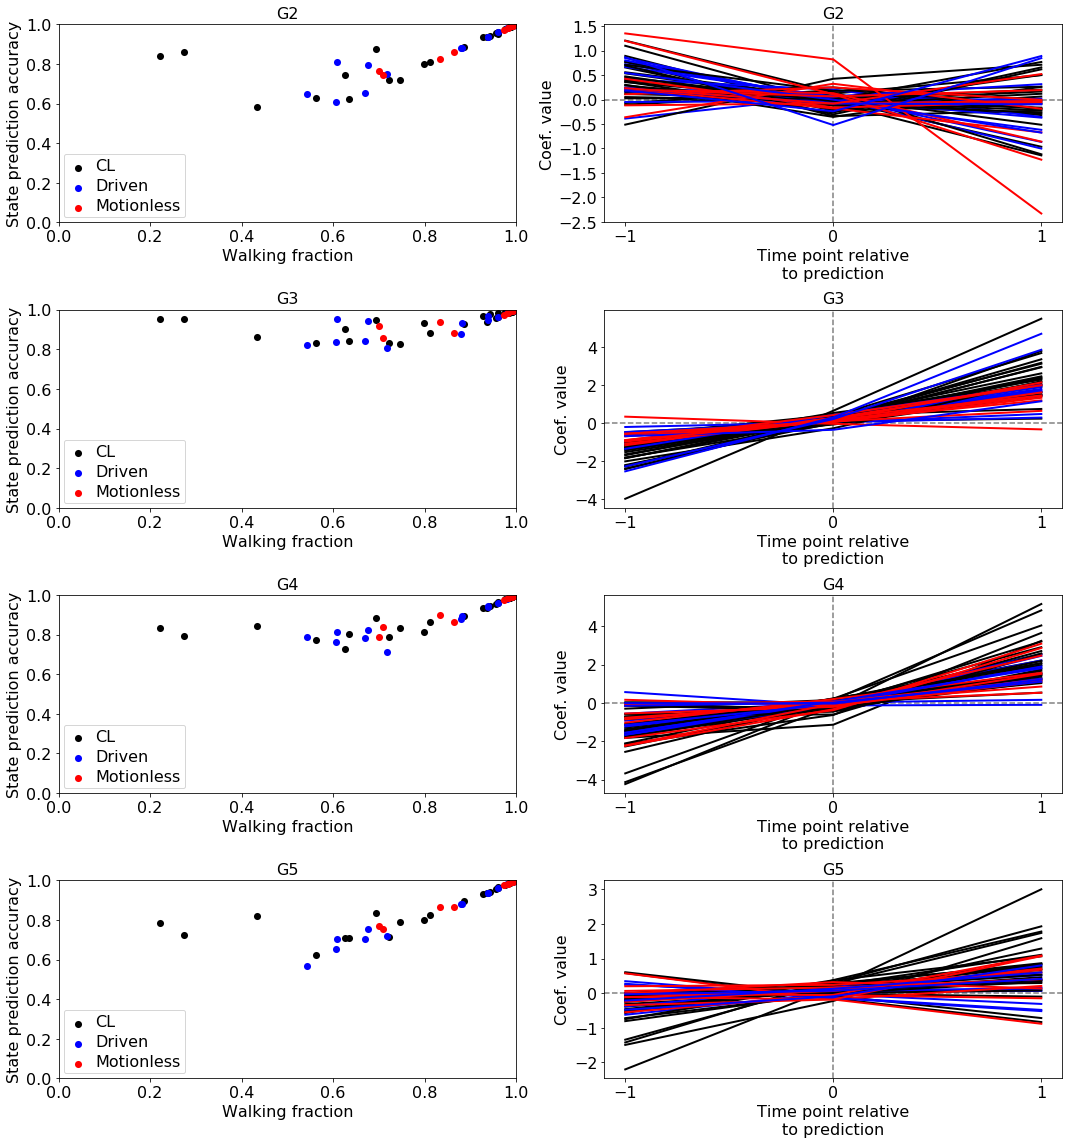

In [18]:
# plot accuracy vs. fraction of time spent walking, and G3S coefs
fig, axs = plt.subplots(4, 2, figsize=(15, 16), tight_layout=True)

keys = ['G2', 'G3', 'G4', 'G5']
coefs = ['G2S', 'G3S', 'G4S', 'G5S']

for key, coef, ax_row in zip(keys, coefs, axs):
    plot_state_classifications(key, coef, ax_row)

Here we see that while G3 indeed contains the best information for classification, G4 also classifies states reasonably well, as do the other two compartments for several trials.

### Plot R^2 vs. n_valid using different predictors

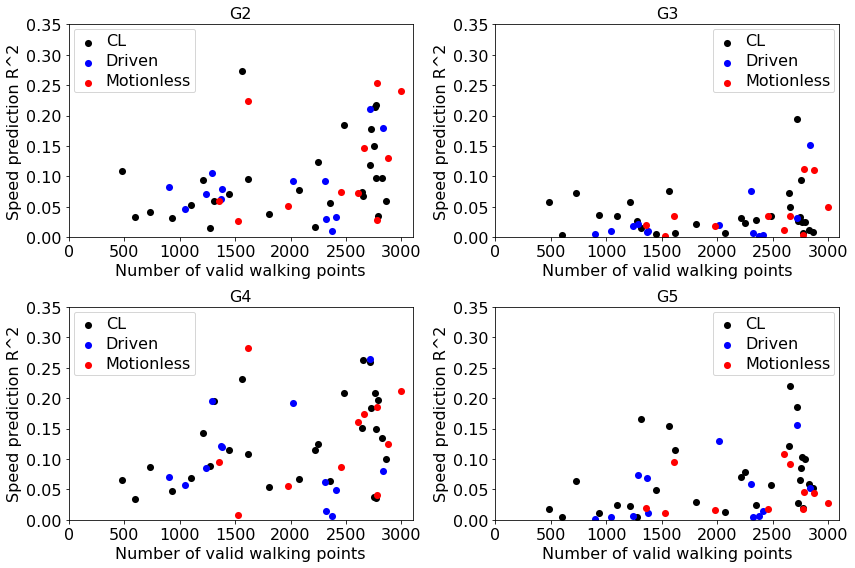

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
    
for key, ax in zip(['G2', 'G3', 'G4', 'G5'], axs.flatten()):
    plot_speed_prediction(key, ax)
    ax.set_xlim(0, 3100)
    ax.set_ylim(0, 0.35)

# Show table of trials and R^2s

In [20]:
import pandas as pd

# make dataframe
df_data = []
for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'G2 (st.)': results_clf['G2'][tr_ctr].acc,
        'G3 (st.)': results_clf['G3'][tr_ctr].acc,
        'G4 (st.)': results_clf['G4'][tr_ctr].acc,
        'G5 (st.)': results_clf['G5'][tr_ctr].acc,
        'G2 (sp.)': results_rgr['G2'][tr_ctr].r2,
        'G3 (sp.)': results_rgr['G3'][tr_ctr].r2,
        'G4 (sp.)': results_rgr['G4'][tr_ctr].r2,
        'G5 (sp.)': results_rgr['G5'][tr_ctr].r2,
    })

columns=[
    'Trial', 'Expt',
    'G2 (st.)', 'G3 (st.)', 'G4 (st.)', 'G5 (st.)',
    'G2 (sp.)', 'G3 (sp.)', 'G4 (sp.)', 'G5 (sp.)',
]
df = pd.DataFrame(df_data, columns=columns)
        
df.round(3)

,Trial,Expt,G2 (st.),G3 (st.),G4 (st.),G5 (st.),G2 (sp.),G3 (sp.),G4 (sp.),G5 (sp.)
0,20170310.Fly2.2,closed_loop,0.995,0.995,0.995,0.995,0.059,0.009,0.100,0.053
1,20170310.Fly2.6,closed_loop,0.996,0.996,0.996,0.996,0.098,0.011,0.135,0.058
2,20170310.Fly3.1,closed_loop,0.990,0.990,0.990,0.990,0.217,0.025,0.149,0.104
3,20170313.Fly1.1,closed_loop,0.581,0.860,0.844,0.822,0.042,0.073,0.086,0.064
4,20170313.Fly1.2,closed_loop,0.813,0.883,0.865,0.825,0.095,0.006,0.109,0.115
5,20170313.Fly1.3,closed_loop,0.885,0.929,0.893,0.897,0.039,0.021,0.055,0.030
6,20170313.Fly1.4,closed_loop,0.957,0.957,0.957,0.957,0.078,0.007,0.067,0.013
7,20170313.Fly1.8,closed_loop,0.937,0.937,0.937,0.937,0.017,0.032,0.114,0.070
8,20170313.Fly3.1,closed_loop,0.717,0.829,0.832,0.792,0.070,0.004,0.115,0.049
9,20170313.Fly3.2,closed_loop,0.934,0.967,0.934,0.929,0.123,0.024,0.124,0.078


### Show trial with highest G4-speed R2

(100, 200)

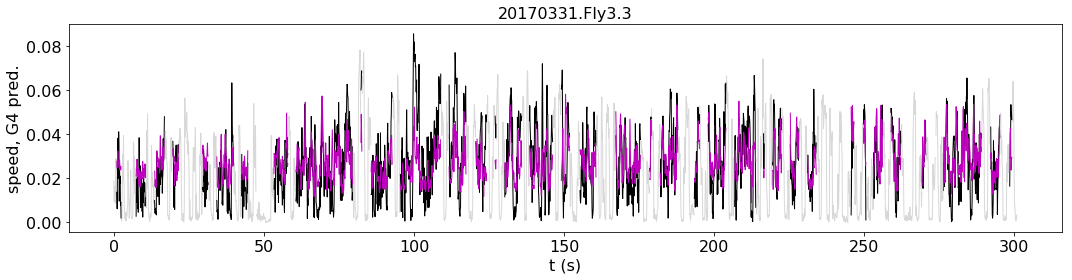

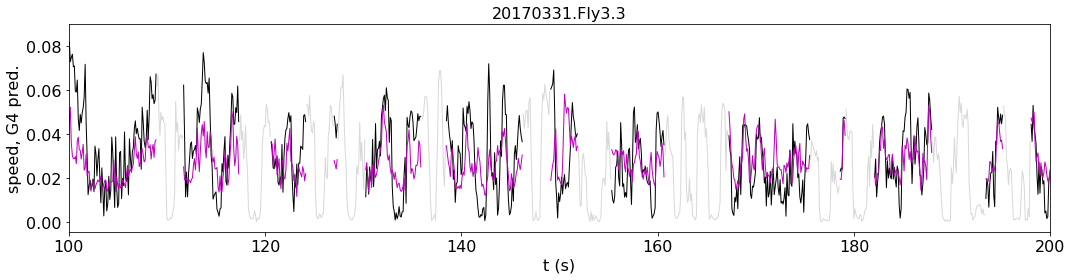

In [21]:
ax = plot_example_speed_prediction('20170331.Fly3.3', 'G4', fig_size=(15, 4))
ax = plot_example_speed_prediction('20170331.Fly3.3', 'G4', fig_size=(15, 4))
ax.set_xlim(100, 200)

(100, 200)

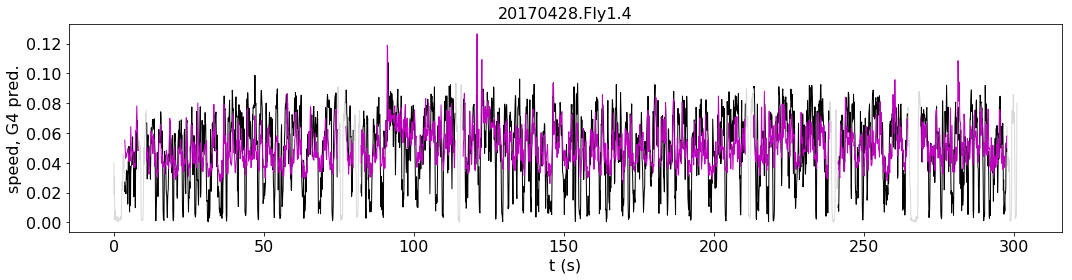

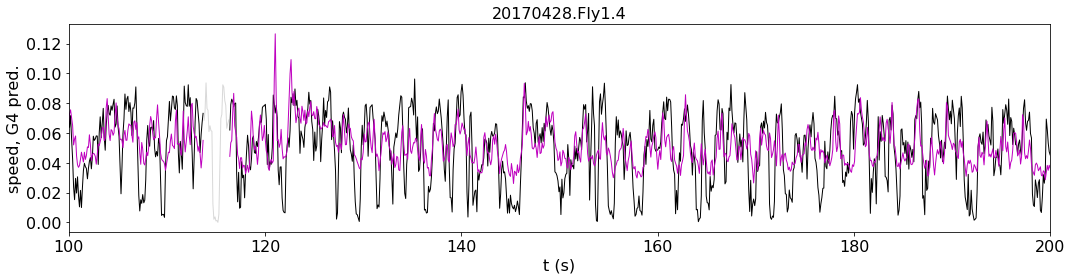

In [22]:
ax = plot_example_speed_prediction('20170428.Fly1.4', 'G4', fig_size=(15, 4))
ax = plot_example_speed_prediction('20170428.Fly1.4', 'G4', fig_size=(15, 4))
ax.set_xlim(100, 200)

# Relationships between predictiveness of different compartments

Finally, we ask whether, say, trials with good G3 state classification tend to have poor G4 state classification, etc. 

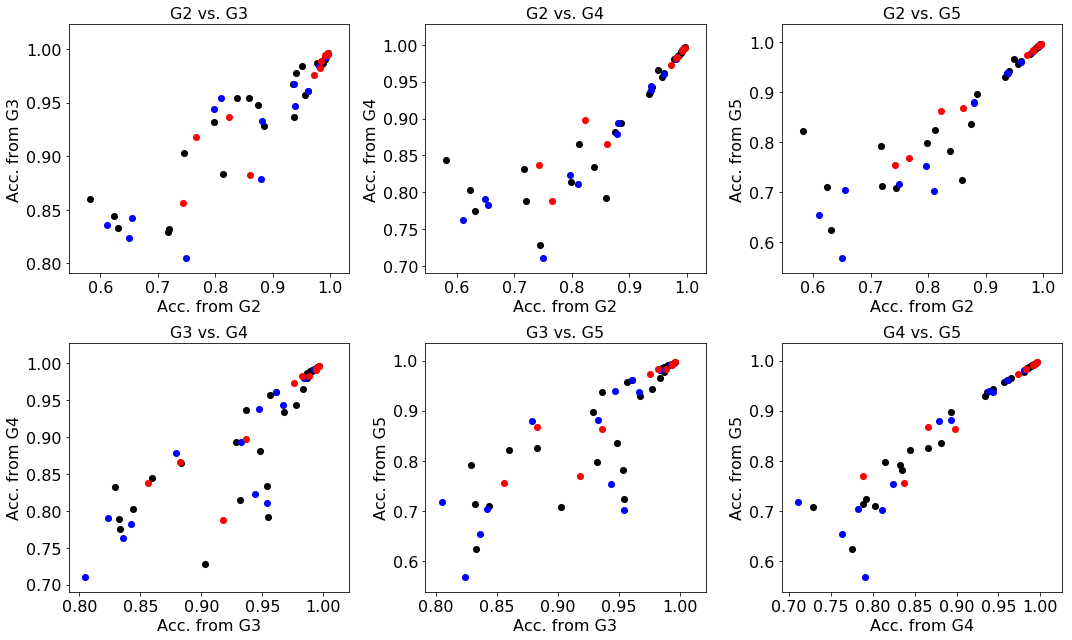

In [25]:
pairs = [('G2', 'G3'), ('G2', 'G4'), ('G2', 'G5'), ('G3', 'G4'), ('G3', 'G5'), ('G4', 'G5')]

# plot relationships between state classification accuracies
fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    accs_0 = np.array([r.acc for r in results_clf[key_0]])
    accs_1 = np.array([r.acc for r in results_clf[key_1]])
    
    ax.scatter(accs_0[closed_mask], accs_1[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(accs_0[driven_mask], accs_1[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(accs_0[mtnless_mask], accs_1[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)
    
    ax.set_xlabel('Acc. from {}'.format(key_0))
    ax.set_ylabel('Acc. from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)

Here we see strong positive correlations among accuracies from all pairs of predictors. This suggests that if a trial's states can be well predicted from one compartment, they're also likely to be well predicted from another compartment.

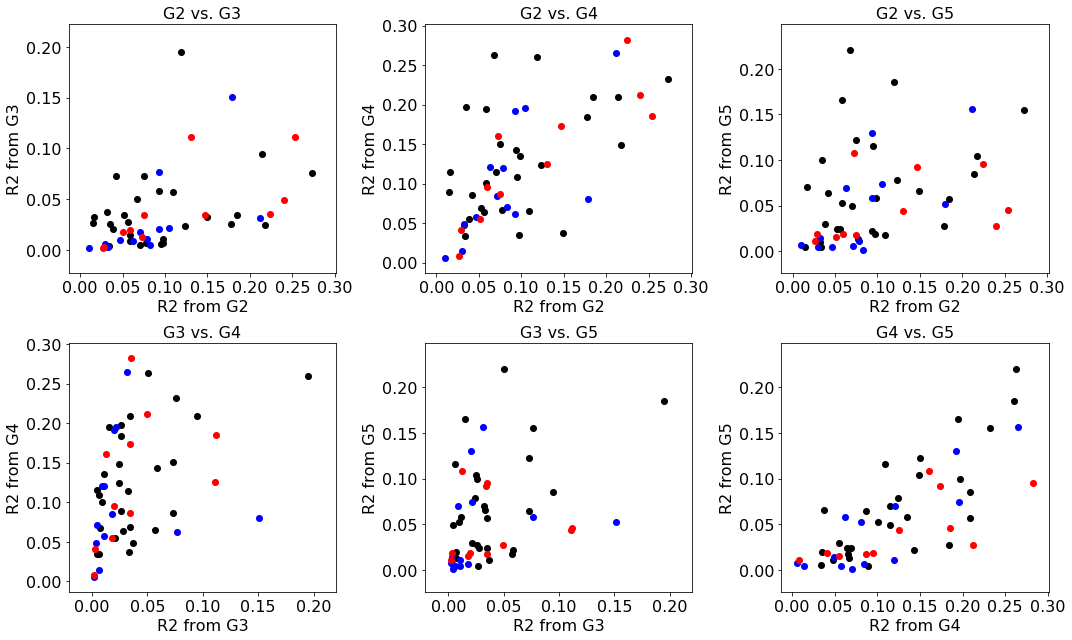

In [26]:
pairs = [('G2', 'G3'), ('G2', 'G4'), ('G2', 'G5'), ('G3', 'G4'), ('G3', 'G5'), ('G4', 'G5')]

# plot relationships between speed prediction r2s
fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    r2s_0 = np.array([r.r2 for r in results_rgr[key_0]])
    r2s_1 = np.array([r.r2 for r in results_rgr[key_1]])
    
    ax.scatter(r2s_0[closed_mask], r2s_1[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(r2s_0[driven_mask], r2s_1[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(r2s_0[mtnless_mask], r2s_1[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)
    
    ax.set_xlabel('R2 from {}'.format(key_0))
    ax.set_ylabel('R2 from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)

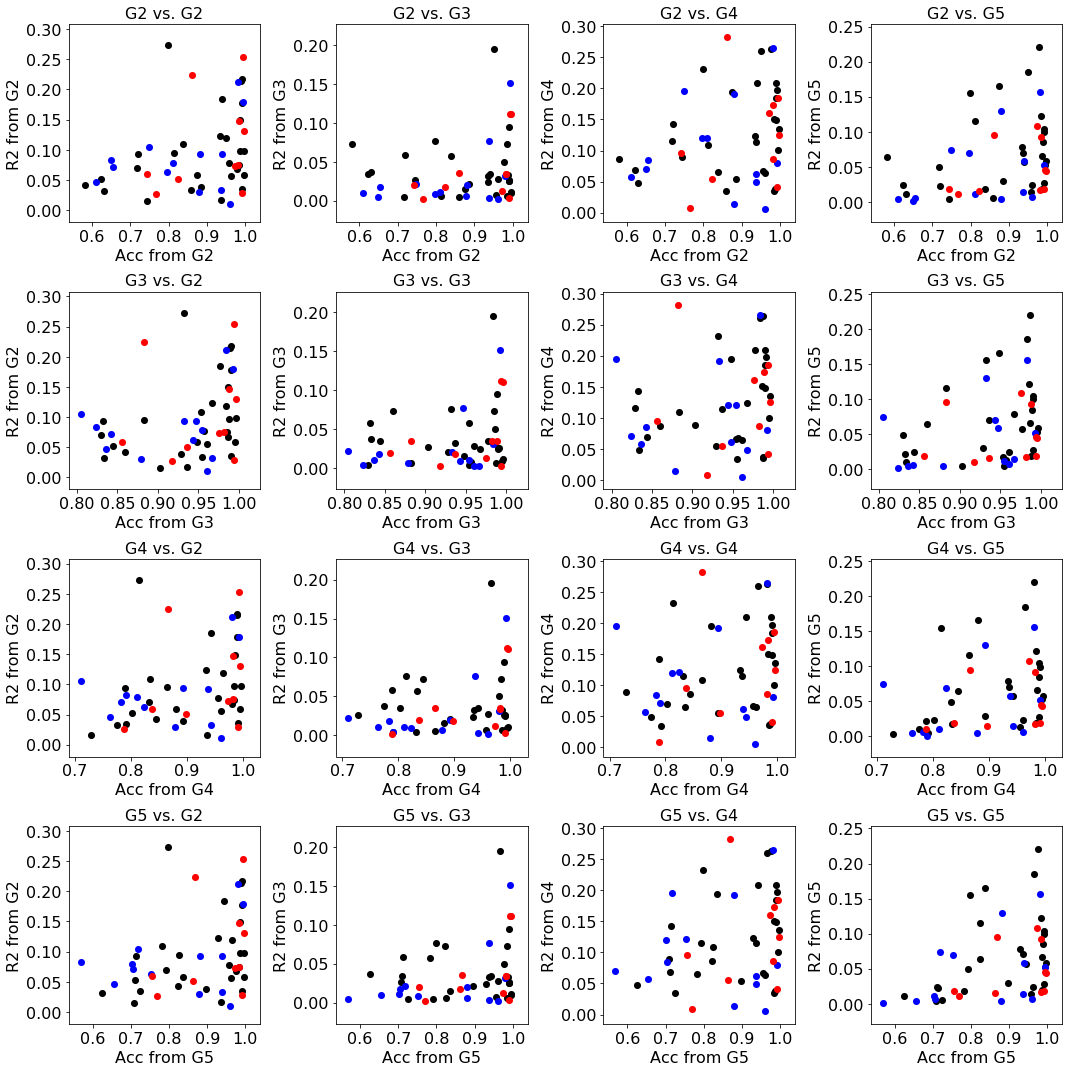

In [27]:
from itertools import product as cproduct

pairs = cproduct(keys, keys)

# plot relationships between state prediction from one compartment and speed prediction from another
fig, axs = plt.subplots(4, 4, figsize=(15, 15), tight_layout=True)

for (key_0, key_1), ax in zip(pairs, axs.flatten()):
    accs = np.array([r.acc for r in results_clf[key_0]])
    r2s = np.array([r.r2 for r in results_rgr[key_1]])
    
    ax.scatter(accs[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    ax.scatter(accs[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    ax.scatter(accs[mtnless_mask], r2s[mtnless_mask], s=50, c=c_dict['motionless'], lw=0)
    
    ax.set_xlabel('Acc from {}'.format(key_0))
    ax.set_ylabel('R2 from {}'.format(key_1))
    ax.set_title('{} vs. {}'.format(key_0, key_1))
    
    set_font_size(ax, 16)

These results are pretty messy, but if anything, we generally see weak positive correlations between state classification accuracy using compartment and speed prediction accuracy using another, again suggesting that certain trials are more predictable in general than others when using single DAN compartments as predictors.